# PA005: High Value Customer Identification (Insiders)

## Ciclo 0 -  Planejamento da solução (IOT)

## Ciclo 1 -  Métricas de Validação de Clusters

1. Feature Engineering
* Recency
* Frequency
* Monetary

2. Métricas de Validação de clusters
* WSS - (Within-Cluster Sum of Squares)
* SS - (Silhouette Score)

3. Cluster Analisys
* Plot 3d
* Cluster profile

## Ciclo 2 - Análise de Silhouette

1. Feature Engineering
* Average Ticket


2. Análise de Silhouette
* Silhouette Analysis


3. Clustering visualization
* UMAP


4. Cluster análise de perfil
* Descrição dos centroides dos clusters

## Ciclo 3 - Feature Engineering I

## Ciclo 4 - Feature Engineering II

## Ciclo 5 - EDA I

1. Feature Engineering
* Criando, organizando e tratando novas features

2. EDA
* Checando e corrigindo features
* Criando report com o profile



## Input - Entrada

1. Problema de negócio

    --Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjunto de dados

    --Vendas de um e-commerce, durante um período de um ano

## Output - Saída

1. A idicação de clientes que farão parte do programa de Insiders

    --Lista: client_id | is_insider
            455534     | yes
            433524     | no
            
2. Relatório com as respostas das perguntas de negócios

    2.0. Quem são as pessoas elegíveis para fazer parte do grupo de Insiders?

    2.1. Quantos clientes farão parte do grupo?
    
    2.2. Quais as principais características desses clientes?
    
    2.3. Qual a porcentagem de contribuição do faturamento vindo dos Insiders?
    
    2.4. Qual a expectativa de faturamento desse grupo para os próximos meses?
    
    2.5. Quais as condições para umma pessoa ser elegível ao Insiders?
    
    2.6. Quais as condições para umma pessoa ser removida do Insiders?
    
    2.7. Qual a garantia que o programa Insiders é melhor que o restante da base?
    
    2.8. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    
    

## Tasks - Tarefas

    0. Quem são as pessoas elegíveis para fazer parte do grupo de Insiders?  
        - O que são clientes de maior "valor"?
        - Faturamento
            - Alto ticket médio
            - Alto LTV
            - Baixa recência
            - Baixa probabilidade de churn
            - Alto basket size
            - Alta previsão LTV
            - Alta propensão de compra
            
        - Custo
            - Baixa taxa de devolução
            
        - Experiência de compra
            - Média alta das avaliações
    
    1. Quantos clientes farão parte do grupo?
        - Número total de clientes
        - % do grupo de Insiders
    
    2. Quais as principais características desses clientes?
        -Características dos clientes:
            - Idade
            - Localização
            
        - Características de consumo:
            - Atributos da clusterização
        
    
    3. Qual a porcentagem de contribuição do faturamento vindo dos Insiders?
            - Faturamento do ano
            - Faturamento dos Insiders
    
    4. Qual a expectativa de faturamento desse grupo para os próximos meses?
            - LTV do grupo Insiders
            - Análise de Cohort
    
    5. Quais as condições para umma pessoa ser elegível ao Insiders?
            - Definir periodicidade
            - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
            
    6. Quais as condições para umma pessoa ser removida do Insiders?
            - Definir periodicidade
            - A pessoa precisa ser dissimilar ou parecido com uma pessoa do grupo
            
    7. Qual a garantia que o programa Insiders é melhor que o restante da base?
            - Teste A/B
            - Teste A/B Bayesiano
            - Teste de hipóteses
    
    8. Quais ações o time de marketing pode realizar para aumentar o faturamento?
            - Desconto
            - Preferência de compra
            - Frente
            - Visita a empresa

## Benchmark de soluções

### 1. Desk research

Modelo RFM
1. Recency
    a) Tempo desde a última compra
    b) Responsividade

2. Frequency
    a) Tempo médio entre as transações
    b) Engajamento
    
3. Monetary 
    a) Total gasto, faturamento
    b) 'High-value purchases'

# 0.0. Imports

In [1]:

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE

from matplotlib          import pyplot        as plt
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import mixture       as mx
from sklearn             import ensemble      as en

from scipy.cluster      import hierarchy     as hc
from plotly              import express       as px
from pandas_profiling    import ProfileReport

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib 

import re
import pickle
import umap.umap_ as umap


/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Helper Functions

In [2]:
%matplotlib inline
def num_attributes(df1):
    
    num_attributes = df1.select_dtypes(['int64', 'float64'])

    #central tendency
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #dispersion
    d1 = pd.DataFrame(num_attributes.apply(np.min)).T
    d2 = pd.DataFrame(num_attributes.apply(np.max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
    return m

## 0.3. Load Data

In [3]:
df_raw = pd.read_csv(r'../data/Ecommerce.csv')


# 1.0. Data Description

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

## 1.2. Data Shape

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NAs


In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill NAs

In [10]:
#remove na
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[-df1['customer_id'].isna()]



In [11]:
len(df_missing)

135080

In [12]:
len(df_not_missing)

406829

In [13]:
#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

#merge
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns
df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)




In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [15]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [16]:
#invoice_no 
# df1['invoice_no'] = df1['invoice_no'].astype(int)


#stock_code 
# df1['stock_code'] = df1['stock_code'].astype(int)


#invoice_date  --> Month --> b
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format=('%d-%b-%y'))


#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive statistics

In [17]:

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [18]:
m1 = num_attributes(df1)
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611121,2.08,96.759763,186.506973,59005.719804
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Investigating

1. Negative quantity (devolution?)
2. Price = 0 (Promo?)

## 1.7.2. Categorical Attributes

In [19]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice no

In [20]:

#invoice_no -- some of them has one char
df_invoice_char = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]   

len(df_invoice_char[df_invoice_char['quantity']<0])


print('Total of invoices with letter: {}'.format(len(df_invoice_char)))
print('Total of negative quantaty: {}'.format(len(df1[df1['quantity']<0])))
print('Letter means negative quantity')

Total of invoices with letter: 9291
Total of negative quantaty: 10624
Letter means negative quantity


#### Stock Code

In [21]:
#all stock codes with char
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

#remove stock code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
# df1 = df1[-df1.isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [22]:
df1.head(2) #remove description


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850


#### Country


In [23]:
df1['country'].value_counts(normalize='True').head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [24]:
df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Data Filtering

In [25]:
df2 = df1.copy()

In [26]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [27]:
 # === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df_returns = df2.loc[df1['quantity'] < 0, :]
df_purchase = df2.loc[df1['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [28]:
df3 = df2.copy()

## 3.1. Feature Creation

In [29]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )

### 3.1.1. Gross Revenue

In [30]:
#calculate gross revenue
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price'] 

#gross revenue by customer
df_monetary = df_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how= 'left')
df_ref.isna().sum()

/tmp/ipykernel_89760/2494157146.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Days from last purchase


In [31]:
#recency 

df_recency = df_purchase.loc[:,['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency  = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 3.1.3. Quantity of items purchase

In [32]:
# Número de compras
df_products = df_purchase.loc[:,['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qt_items'})
df_ref = pd.merge(df_ref, df_products, on='customer_id', how='left')

### 3.1.4. Quantity of purchase

In [33]:

# Número de compras
df_invoice = df_purchase.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qt_invoice'})
df_ref = pd.merge(df_ref, df_invoice, on='customer_id', how='left')

### 3.1.4. Quantity of products purchase

In [34]:
# Número de compras
df_stock_code = df_purchase.loc[:,['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qt_products'})
df_ref = pd.merge(df_ref, df_stock_code, on='customer_id', how='left')

### 3.1.5. Average Ticket Value

In [35]:
#avg ticket
df_avgticket = df_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avgticket, on='customer_id', how='left')

### 3.1.6. Average Recency Days

In [36]:
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_invoice_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_invoice_date']).days +1 if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)
df_aux = df_aux[['customer_id', 'avg_recency_days']].dropna()

#calculate avg recency days
df_aux =  df_aux.groupby('customer_id').mean().reset_index()

#merge
df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qt_items              91
qt_invoice            91
qt_products           91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.6. Frequency

In [37]:
df_aux = (df_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
                                                            max_ = ('invoice_date', 'max'),
                                                            min_ = ('invoice_date', 'min'),
                                                            days = ('invoice_date', lambda x: (x.max() - x.min()).days ),
                                                            buys = ('invoice_no', 'count'))).reset_index()

# #calculate frequency
df_aux['frequency'] = df_aux[['buys', 'days']].apply(lambda x: x['buys']/x['days'] if x['days']!= 0 else 0, axis=1)


#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qt_items              91
qt_invoice            91
qt_products           91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.7. Returns


In [38]:
df_aux = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qt_returns'})
df_aux['qt_returns'] = -1*df_aux['qt_returns']

#merge
df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qt_items              91
qt_invoice            91
qt_products           91
avg_ticket            91
avg_recency_days    2816
frequency             91
qt_returns          4191
dtype: int64

In [39]:
df_ref.loc[df_ref['qt_returns'].isna(), 'qt_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qt_items              91
qt_invoice            91
qt_products           91
avg_ticket            91
avg_recency_days    2816
frequency             91
qt_returns             0
dtype: int64

### 3.1.7. Unique Basket Size-  Unidades de produtos distintos por cesto


In [40]:
df_aux = df_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id').agg(
                                                                n_purchase = ('invoice_no', 'nunique'),
                                                                n_products = ('stock_code', 'count')).reset_index()

#calculate avg unique basket size
df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']
df_aux.head()

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_unique_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qt_items                    91
qt_invoice                  91
qt_products                 91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qt_returns                   0
avg_unique_basket_size      91
dtype: int64

### 3.1.8.  Basket Case -  Unidades de produtos por cesto


In [41]:
df_aux = df_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id').agg(
                                                                n_purchase = ('invoice_no', 'nunique'),
                                                                n_products = ('quantity', 'sum')).reset_index()

#calculate avg basket size
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']
df_aux.head()

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qt_items                    91
qt_invoice                  91
qt_products                 91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qt_returns                   0
avg_unique_basket_size      91
avg_basket_size             91
dtype: int64

In [42]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qt_items,qt_invoice,qt_products,avg_ticket,avg_recency_days,frequency,qt_returns,avg_unique_basket_size,avg_basket_size
0,17850,5391.21,372.0,1733.0,34.0,297.0,18.152222,-34.500000,34.000000,40.0,8.735294,50.970588
1,13047,3232.59,56.0,1390.0,9.0,171.0,18.904035,-26.250000,0.028391,35.0,19.000000,154.444444
2,12583,6705.38,2.0,5028.0,15.0,232.0,28.902500,-22.187500,0.040431,50.0,15.466667,335.200000
3,13748,948.25,95.0,439.0,5.0,28.0,33.866071,-91.666667,0.017986,0.0,5.600000,87.800000
4,15100,876.00,333.0,80.0,3.0,3.0,292.000000,-7.600000,0.075000,22.0,1.000000,26.666667


# 4.0. Exploratory Data Analisys

In [43]:
df4 = df_ref.dropna()
df4.isna().sum()
# analisar melhor os nA's no próximo ciclo


customer_id               0
gross_revenue             0
recency_days              0
qt_items                  0
qt_invoice                0
qt_products               0
avg_ticket                0
avg_recency_days          0
frequency                 0
qt_returns                0
avg_unique_basket_size    0
avg_basket_size           0
dtype: int64

## 4.1. Univariate Analysis

### Notes
 1. Clusteres coeses - separados
 2. Métricas
     * Max, min, range (dispersão)
     * média e mediana
     * Desvio padrão e variância
     * Coeficiente de variação (dp/mean)
     * Distribuição
     
     
**EDA** 

* gross_revenue => high variance
* recency days => low variance
* qtd items => mean very high (investigate) high variance
* qtd invoice => mean similar to median, low variance
* qtd products => low variance
* avg ticket => high variance
* avg recency days => low variance
* frequency => high variance





In [44]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')

### 4.1.1. Gross Revenue

In [45]:
df4.head().sort_values('gross_revenue', ascending=False)
# df4[df4['customer_id']==12583]
df4.head()


,customer_id,gross_revenue,recency_days,qt_items,qt_invoice,qt_products,avg_ticket,avg_recency_days,frequency,qt_returns,avg_unique_basket_size,avg_basket_size
0,17850,5391.21,372.0,1733.0,34.0,297.0,18.152222,-34.500000,34.000000,40.0,8.735294,50.970588
1,13047,3232.59,56.0,1390.0,9.0,171.0,18.904035,-26.250000,0.028391,35.0,19.000000,154.444444
2,12583,6705.38,2.0,5028.0,15.0,232.0,28.902500,-22.187500,0.040431,50.0,15.466667,335.200000
3,13748,948.25,95.0,439.0,5.0,28.0,33.866071,-91.666667,0.017986,0.0,5.600000,87.800000
4,15100,876.00,333.0,80.0,3.0,3.0,292.000000,-7.600000,0.075000,22.0,1.000000,26.666667


### 4.1.2. Recency Days

In [46]:
df4.sort_values('recency_days', ascending=False).head() 



,customer_id,gross_revenue,recency_days,qt_items,qt_invoice,qt_products,avg_ticket,avg_recency_days,frequency,qt_returns,avg_unique_basket_size,avg_basket_size
63,15922,369.50,373.0,138.0,1.0,11.0,33.590909,0.0,0.0,2.0,11.000000,138.000000
82,16048,256.44,373.0,144.0,2.0,8.0,32.055000,-287.0,0.0,1.0,4.000000,72.000000
0,17850,5391.21,372.0,1733.0,34.0,297.0,18.152222,-34.5,34.0,40.0,8.735294,50.970588
140,15363,326.00,372.0,144.0,1.0,16.0,20.375000,-130.0,0.0,1.0,16.000000,144.000000
160,16781,311.25,372.0,113.0,1.0,17.0,18.308824,-6.0,0.0,2.0,17.000000,113.000000


### 4.1.3. Qtd Items

In [47]:
aux = df4.sort_values('qt_items', ascending=False).head() 

#investigating top 5  of qt_items
aux[['customer_id','qt_items', 'qt_returns']]

#top 2 customer is an strange outlier of qtd items

,customer_id,qt_items,qt_returns
1017,14646,196844.0,288.0
66,14911,80263.0,3332.0
1150,12415,77373.0,427.0
433,17450,69993.0,952.0
15,17511,64549.0,1535.0


### 4.1.4. Qtd Invoice


In [48]:
aux = df4.sort_values('qt_invoice', ascending=False).head() 

#understanding top 5 qtd invoice
aux[['qt_invoice', 'gross_revenue','avg_ticket','avg_basket_size']]


,qt_invoice,gross_revenue,avg_ticket,avg_basket_size
47,206.0,32317.32,7.056183,123.839806
66,199.0,140450.72,24.757751,403.331658
68,124.0,40967.72,5.226808,185.911290
278,97.0,58825.83,32.357442,320.309278
96,91.0,12021.65,4.455764,68.296703


### 4.1.5. Qtd Products

In [49]:
aux = df4.sort_values('qt_products', ascending=False).head() 
aux[['qt_products','qt_invoice', 'gross_revenue','avg_ticket','avg_basket_size']]

,qt_products,qt_invoice,gross_revenue,avg_ticket,avg_basket_size
68,7838.0,124.0,40967.72,5.226808,185.911290
66,5673.0,199.0,140450.72,24.757751,403.331658
4405,5095.0,17.0,53258.43,10.453078,960.941176
47,4580.0,206.0,32317.32,7.056183,123.839806
96,2698.0,91.0,12021.65,4.455764,68.296703


### 4.1.6. Avg Ticket

In [50]:
aux = df4.sort_values('avg_ticket', ascending=False).head(10) 

#investigating outliers
aux[['customer_id','qt_items','avg_ticket', 'qt_returns']]


,customer_id,qt_items,avg_ticket,qt_returns
1262,15749,18028.0,4453.430000,9014.0
1820,18087,3906.0,3202.920000,336.0
1136,16532,2016.0,1687.200000,0.0
601,12755,1491.0,952.987500,624.0
3779,12798,5256.0,872.130000,0.0
249,17949,30450.0,841.021449,2878.0
186,15299,2947.0,651.168333,5.0
2548,16308,8000.0,640.000000,0.0
5405,16986,1040.0,624.400000,0.0
2843,18080,642.0,615.750000,0.0


### 4.1.7. Avg Recency days

In [51]:
aux = df4.sort_values('avg_recency_days', ascending=True).head() 

# aux

## 4.2 Bivariate Analysis

In [52]:
df4.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qt_items',
       'qt_invoice', 'qt_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qt_returns', 'avg_unique_basket_size', 'avg_basket_size'],
      dtype='object')

In [53]:
df4.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qt_items',
       'qt_invoice', 'qt_products', 'avg_ticket', 'avg_recency_days',
       'frequency', 'qt_returns', 'avg_unique_basket_size', 'avg_basket_size'],
      dtype='object')

## 4.3. Estudo do Espaço

In [54]:
 df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [55]:
mm = pp.MinMaxScaler()

# 
df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
df43['qt_invoice']          = mm.fit_transform( df43[['qt_invoice']])
df43['qt_items']             = mm.fit_transform( df43[['qt_items']])
df43['qt_products']          = mm.fit_transform( df43[['qt_products']])
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qt_returns']           = mm.fit_transform( df43[['qt_returns']])
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )


X = df43.copy()

### 4.3.1. PCA

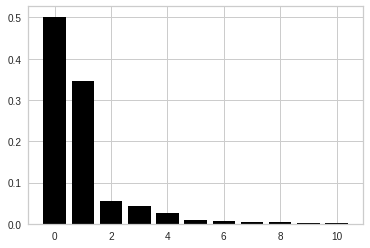

In [57]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )


<AxesSubplot:xlabel='0', ylabel='1'>

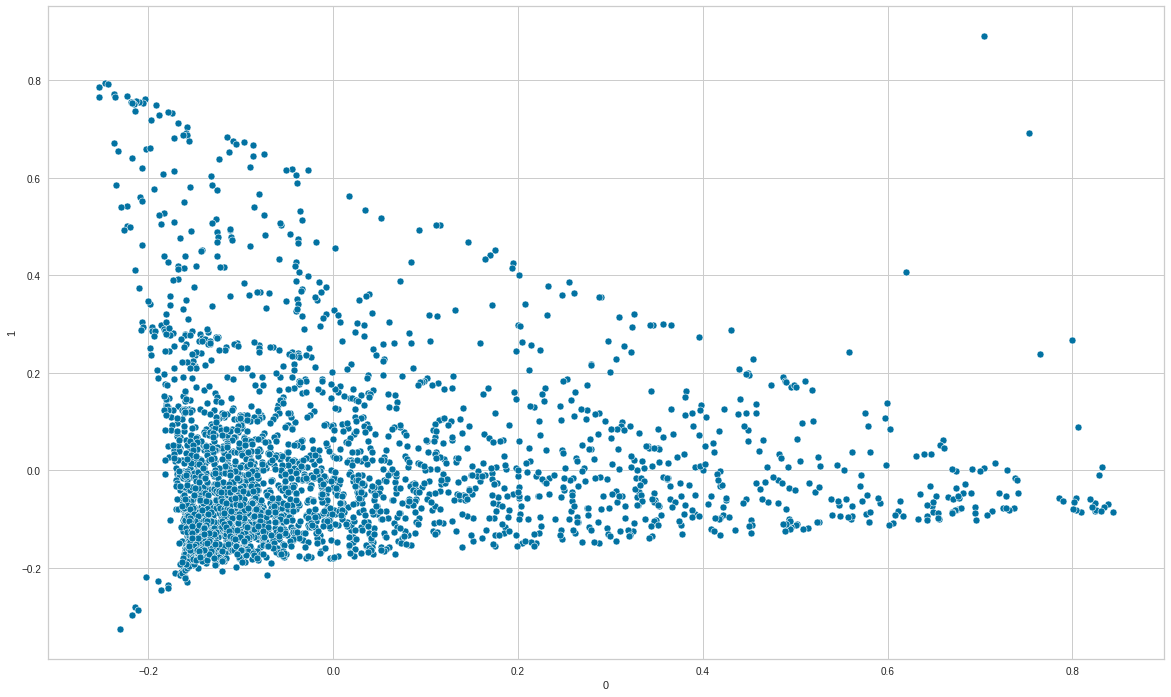

In [58]:
plt.figure(figsize=(20,12))
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

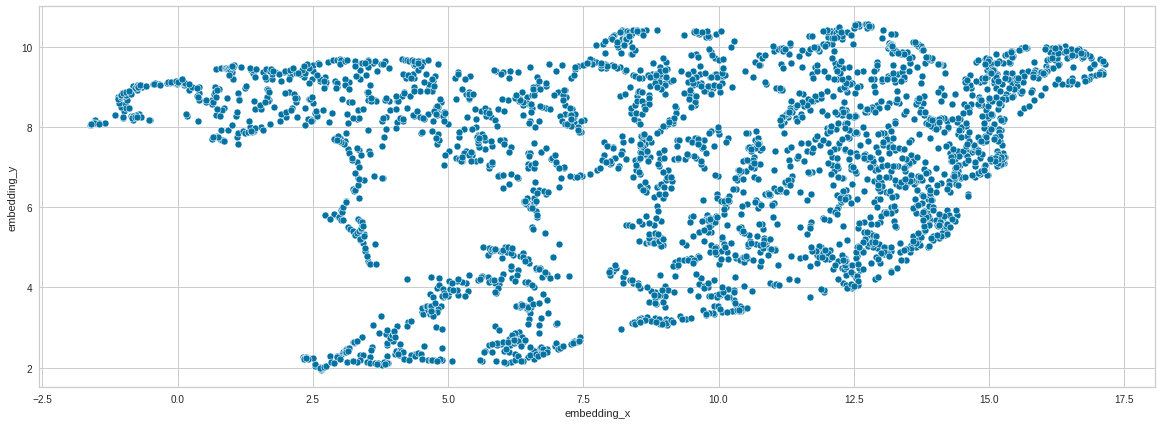

In [59]:


reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform(X)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

plt.figure(figsize=(20,7));
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_pca);

### 4.3.3. t-SNE

/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


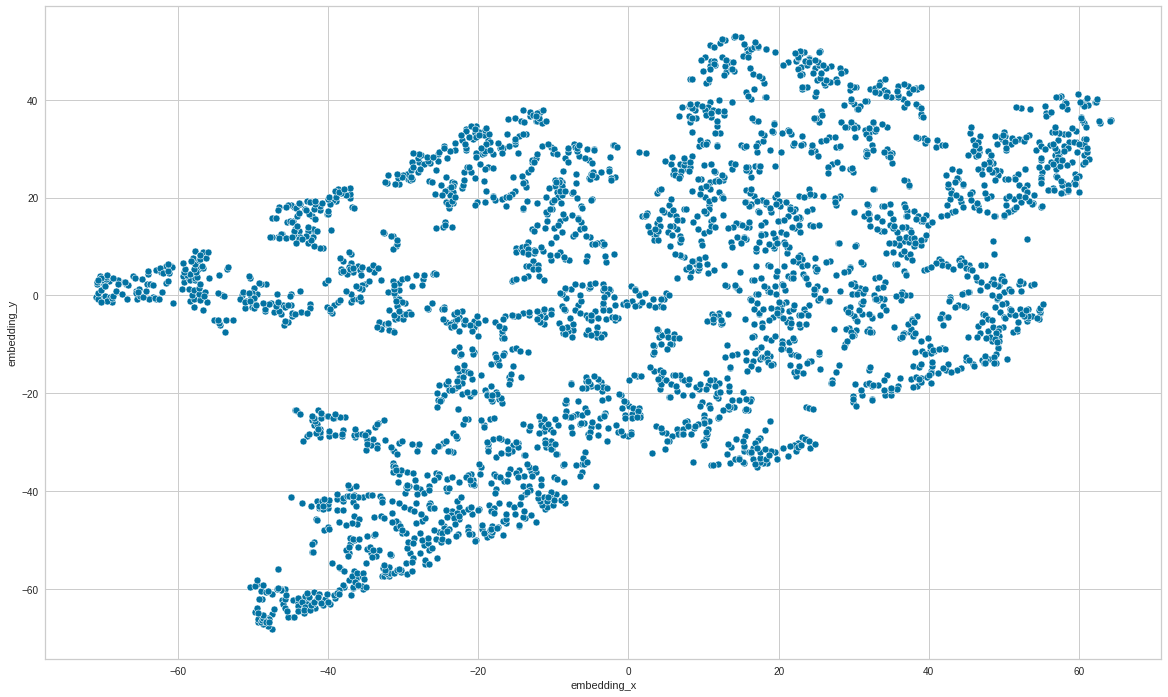

In [60]:
reducer = TSNE( n_components=2,n_jobs=-1, random_state=3)
embedding = reducer.fit_transform(X)

df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]
plt.figure(figsize=(20,12));
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_pca);

### 4.3.4. Tree-Based Embedding

In [61]:
# #training dataset
# X = df4.drop(['gross_revenue','customer_id'], axis=1)
# y = df4['gross_revenue']

# #model definition
# rf_model = en.RandomForestRegressor(random_state=42, n_estimators=100)

# #model training
# rf_model.fit(X,y)

#leaf


#dataframe leaf
# df_leaf = pd.DataFrame(rf_model.apply(X))
df_leaf = pickle.load(open('../data/df_leaf.pkl', 'rb'))

In [62]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2991,2716,3323,3337,2763,3147,3227,3137,3166,3364,...,3185,3177,3200,3059,3043,3127,3186,2832,3356,3319
1,2961,2929,3039,2967,2752,3131,2924,2830,3119,2905,...,2548,2888,2881,3024,3146,3013,2916,2799,2972,2825
2,3633,3606,3590,3406,3574,3659,3629,3546,3680,3615,...,3593,3435,3560,3482,3604,3455,3526,3620,3565,3650
3,1274,1412,1758,1489,2019,1450,2108,1441,1665,1717,...,1871,1744,2026,1881,1921,2260,1453,1195,1987,2100
4,354,720,572,708,137,705,743,688,191,197,...,331,192,595,544,196,156,188,705,706,175


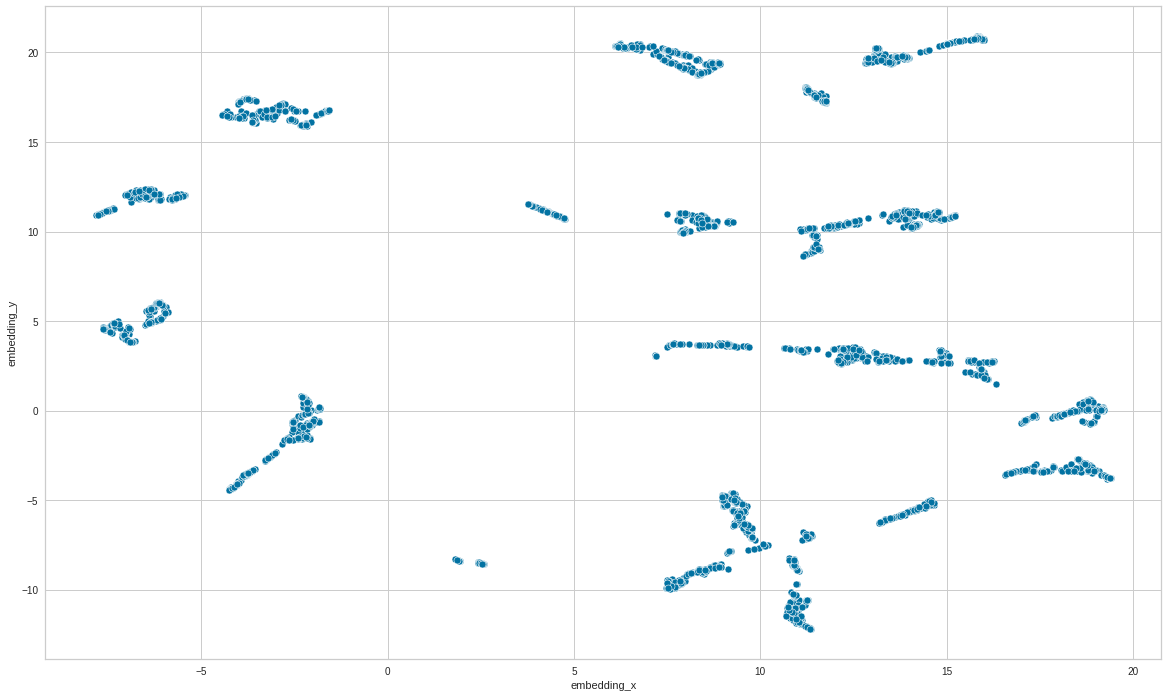

In [63]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform(df_leaf)

df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

plt.figure(figsize=(20,12));
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_tree);

In [64]:
df_leaf.shape

(2968, 100)

# 5.0. Data Preparation

Padronização  --> Premissa: Os dados vieram de uma distribuição normal
Rescale  --> Não  promissa que os dados vieram de uma distribuição normal

**Teste de normalidade**

QQ Plot  -->   Quantile Quantile Plot (Quantile teorica x Quantile real)

Ks Teste  --> Teste de HIpótese: se p_value > 0.5 Distribuição normal

**Detecção de outliers**

 Boxplot --> Pontos acima são considerados outliers
 IRQ *2.5 --> Acima desse valor é outlier
 
 Z-score > 3    --> Outlier
  Z-score < -3    --> Outlier

**REGRA DO CORAÇÃO**
1. Distribuição normal e não possui outlier  --> Standard Scaler
2. Distribuição normal e possui outlier  --> Robust Scaler
3. Não tem distribuição normal  -->  Min Max Scaler


In [65]:
df5 = df_tree.copy()
df5_aux = df4.copy()

In [66]:
# mms = pp.MinMaxScaler()
# rs = pp.RobustScaler()
# ss = pp.StandardScaler()

# df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])   #sem dist normal
# df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
# df5['qt_items'] = mms.fit_transform(df5[['qt_items']])
# df5['qt_invoice'] = mms.fit_transform(df5[['qt_invoice']])
# df5['qt_products'] = mms.fit_transform(df5[['qt_products']])
# # df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])
# # df5['avg_recency_days'] = mms.fit_transform(df5[['avg_recency_days']])
# df5['frequency'] = mms.fit_transform(df5[['frequency']])
# df5['qt_returns'] = mms.fit_transform(df5[['qt_returns']])
# # df5['avg_unique_basket_size'] = rs.fit_transform(df5[['avg_unique_basket_size']])
# # df5['avg_basket_size'] = mms.fit_transform(df5[['avg_basket_size']])
# variable = 'avg_basket_size'

# #remove averages

In [68]:
# #Dados AS iS
# print('Max: {}  Min: {}'.format(df5_aux[variable].max(),df5_aux[variable].min() ))
# sns.displot(df5_aux[variable]);

In [69]:
# #Dados Normalizados/Rescalados
# print('Max: {}  Min: {}'.format(df5[variable].max(),df5[variable].min() ))
# sns.displot(df5[variable]);

In [70]:
# sns.boxplot(df5_aux[variable]);

# 6.0. Feature Selection

In [71]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qt_products', 'frequency', 'qt_returns']
# df6 = df5[cols_selected].copy()
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning

In [72]:
X = df6.copy()
clusters = np.arange(2, 30, 1)

X.head()

,embedding_x,embedding_y
0,-7.714067,11.011308
1,-4.006877,17.243580
2,-3.055864,-2.401886
3,7.636554,3.730672
4,10.896976,-8.273656


## 7.1. KMeans


In [118]:
kmeans_list = []
for k in clusters:

    #model definition
    kmeans_model = c.KMeans(n_clusters=k, random_state=42)

    #model training
    kmeans_model.fit(X)

    #model predict
    labels = kmeans_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

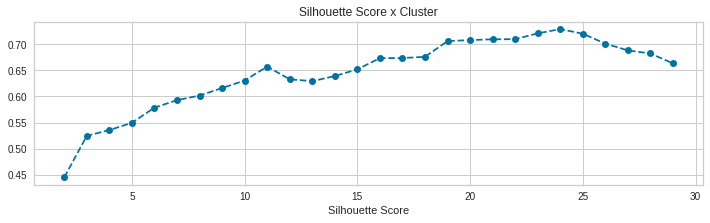

In [119]:
plt.figure(figsize=(12,3));
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel('Cluster');
plt.xlabel('Silhouette Score');
plt.title('Silhouette Score x Cluster');



## 7.2. GMM

In [72]:
gmm_list=[]

for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

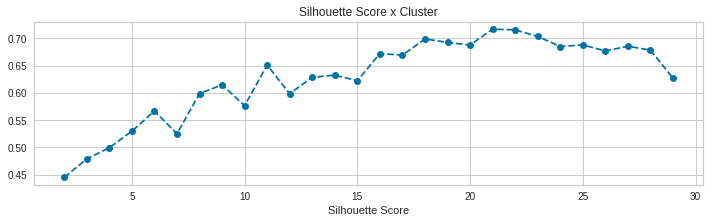

In [73]:
plt.figure(figsize=(12,3));
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.xlabel('Cluster');
plt.xlabel('Silhouette Score');
plt.title('Silhouette Score x Cluster');

## 7.3. H-Clustering

In [74]:
hc_list = []

for k in clusters:
    #model definition & training
    hc_model = hc.linkage(X, 'ward')


    #model predict
    labels = hc.fcluster(hc_model,k, criterion='maxclust')

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

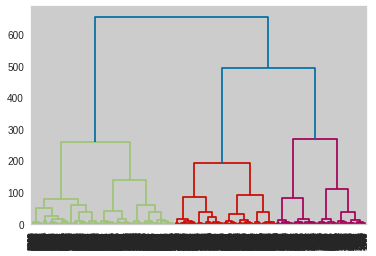

<Figure size 1440x864 with 0 Axes>

In [75]:
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8);
plt.figure(figsize=(20,12));
plt.show();

## 7.4. DBSCAN

In [76]:
eps = 2.1
min_samples = 20

#model definition
dbscan_model = c.DBSCAN(min_samples=min_samples, eps = eps)

#model training & predict
labels = dbscan_model.fit_predict(X)

#model performance
sil = m.silhouette_score(X, labels, metric='euclidean')
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( np.unique( labels.tolist() ) ) ) )
print( np.unique( labels.tolist() ) )

Silhouette Score: 0.5968757271766663
Number of Clusters: 11
[ 0  1  2  3  4  5  6  7  8  9 10]


In [77]:
from sklearn.neighbors import NearestNeighbors 

In [78]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

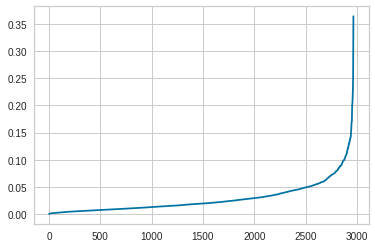

In [79]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances );

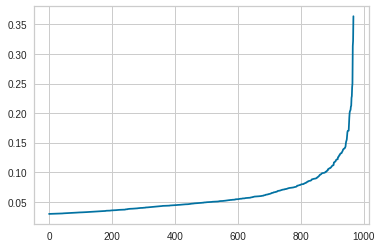

In [80]:
plt.plot( distances[2000:] );

In [81]:
# dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [83]:
df_results = pd.DataFrame({'KMeans': kmeans_list, 'GMM': gmm_list, 'HC': hc_list}).T
df_results.columns = clusters
df_results = df_results.style.highlight_max(color='lightgreen', axis=1)

In [84]:
df_results

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
KMeans,0.445261,0.524626,0.535700,0.549533,0.578540,0.592816,0.601669,0.615973,0.630297,0.657009,0.632728,0.629137,0.638855,0.651754,0.673111,0.673288,0.675682,0.705698,0.707607,0.709216,0.709336,0.720524,0.728563,0.719819,0.700783,0.687951,0.682004,0.663074
GMM,0.445261,0.479151,0.499599,0.529877,0.566893,0.525079,0.598781,0.614707,0.576548,0.651056,0.598460,0.628676,0.632364,0.622319,0.671940,0.669160,0.698756,0.692361,0.687634,0.716734,0.715384,0.703333,0.684894,0.687753,0.676901,0.685388,0.678334,0.626924
HC,0.431502,0.524626,0.539337,0.549533,0.575705,0.596376,0.604704,0.618756,0.633080,0.660086,0.632736,0.644810,0.649602,0.659166,0.666448,0.671665,0.689530,0.706784,0.708434,0.707085,0.714077,0.719363,0.727430,0.719942,0.719768,0.700399,0.696778,0.684385


## 7.6. Silhouette Analysis

In [120]:
# fig, ax = plt.subplots( 3, 2 )
# fig.set_size_inches( 25, 20 )

# for k in clusters:
#     q, mod = divmod( k, 2 )
    
#     ax[q-1, mod].set_xlim( [ -0.1, 1] )
#     ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
#     # model definition & training
#     hc_model = hc.linkage( X, 'ward' )

#     # model predict
#     labels = hc.fcluster( hc_model, k, criterion='maxclust' )

#     # performance
#     ss = m.silhouette_score( X, labels, metric='euclidean' )
#     print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

#     samples_silhouette_values = m.silhouette_samples( X, labels )

#     y_lower = 10
#     for i in range( k ):

#         # select clusters
#         ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
#         # sort values
#         ith_samples_silhouette_values.sort()

#         # size clusters
#         size_cluster_i = ith_samples_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
        
# #         cmap = cm.get_cmap( 'Spectral' )
# #         color = cmap( i / k )

#         ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
#         y_lower = y_upper + 10
        
#     ax[q-1, mod].set_yticks([])
#     ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0. Model Training

## 8.1. KMeans

In [121]:
# #model definition
# k = 8
# kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=3)

# #model training
# kmeans.fit(X)

# #clustering
# labels = kmeans.labels_

## 8.2. GMM

In [97]:
# # model definition
# k = 8

# ## model definition
# gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=3 )


gmm_model = pickle.load(open('../models/gmm_model.pickle', 'rb'))
# model training
gmm_model.fit( X )

# model predict
labels = gmm_model.predict( X )



In [98]:
## SS ( Silhouette Score )
print( 'SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )

SS value: 0.6046755909919739


# 9.0. Cluster Analisys

In [99]:
df9 = X.copy()
df9['cluster'] = labels


## 9.1. Visualization Inspection

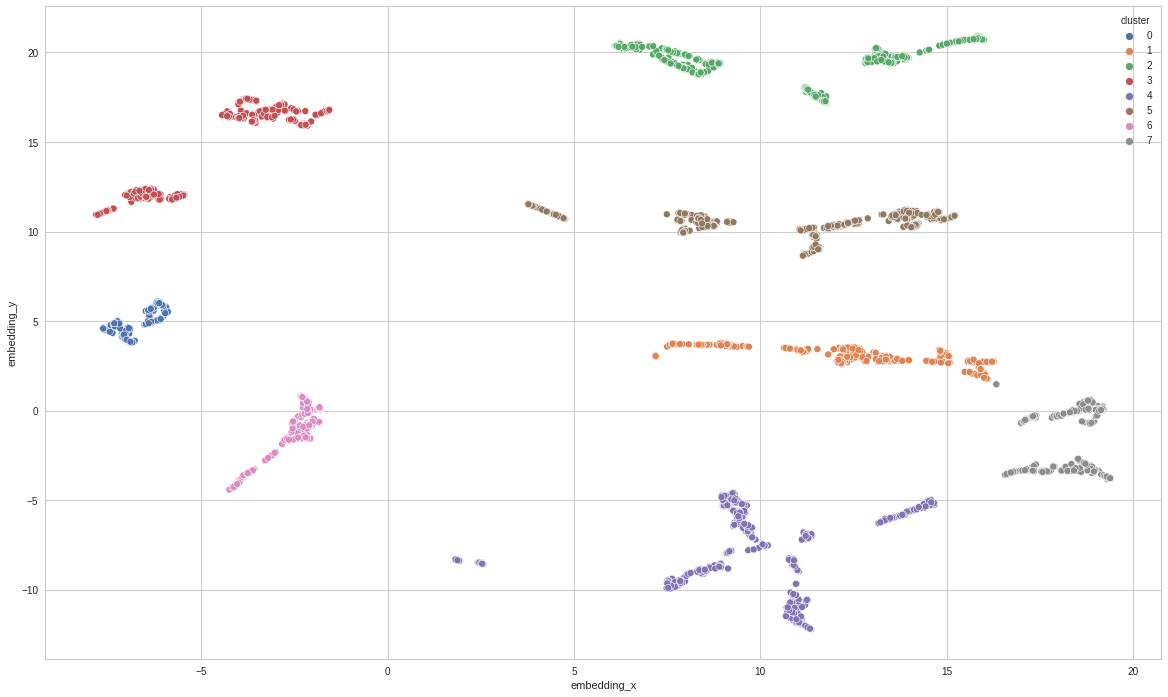

In [147]:
plt.figure(figsize=(20,12))
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

In [148]:


# visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
# visualizer.fit(X)
# visualizer.finalize()

## 9.2. 2d Plot

## 9.1. Visualization Inspection

In [149]:
# px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')

## 9.2. Cluster Profile

In [100]:
df92 = df4[cols_selected].copy()

df92['cluster']= labels

 # Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qt_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qt_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

# df92.columns

# aux0 = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()


# # aux1 = aux1.drop('customer_id', axis=1)
# df92 = df92[['gross_revenue', 'recency_days', 'qt_products', 'frequency', 'qt_returns', 'cluster']].groupby('cluster').mean().reset_index()
# df92 = pd.merge(df92, aux0, on='cluster', how='left')



,cluster,customer_id,perc_customer,gross_revenue,recency_days,qt_products,frequency,qt_returns
6,6,255,8.591644,7760.927451,22.698039,336.725490,0.077465,81.882353
4,4,605,20.384097,4348.972661,107.849587,91.846281,0.052217,79.856198
0,0,176,5.929919,3900.387727,27.022727,229.409091,0.037128,36.562500
3,3,364,12.264151,2589.838654,40.629121,161.373626,0.124422,22.862637
2,2,432,14.555256,1769.042361,36.199074,118.895833,0.035003,22.085648
5,5,467,15.734501,1116.949893,66.447537,75.486081,0.041725,13.145610
1,1,368,12.398922,799.574755,76.122283,61.801630,0.050979,6.016304
7,7,301,10.141509,580.879668,85.069767,48.039867,0.049669,5.664452


Cluster   |   Nome

6         |  Insider

4         |  Bad Users (?)

0         |  More Revenue

2         |  More products

5         |  Less recency

1         |  Hibernating

7         |  Sleeping
  

# 10.0. Análise Exploratória de Dados


In [77]:
df10 = df92.copy()
df10.head()
# df10.to_csv('../data/clusters.csv')

,customer_id,gross_revenue,recency_days,qt_products,frequency,qt_returns,cluster
0,17850,5391.21,372.0,297.0,34.000000,40.0,3
1,13047,3232.59,56.0,171.0,0.028391,35.0,3
2,12583,6705.38,2.0,232.0,0.040431,50.0,6
3,13748,948.25,95.0,28.0,0.017986,0.0,1
4,15100,876.00,333.0,3.0,0.075000,22.0,4


## 10.1. Mindmap de Hipóteses

1. Afirmação
2. Comparação entre variáves
3. Valor base de comparação

## 10.2. Hipóteses do Negócio

### Hipóteses Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes**
7. **A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.**
8. **O percentil do gmv pelos clientes insiders.**
9. **Bad users tem 80% do faturamento retornado em devolução**


#### H1: Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras

**Verdadeiro** O cluster insider possuem um volume de compra de produtos de 77% do total.

In [78]:
df_aux = df10[['qt_products', 'cluster']].groupby('cluster').sum().reset_index()

#total products
total = df10['qt_products'].sum()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==6, 'qt_products']

print('% Sales Insiders: {:.2f}%'.format((total - df_aux_insider.sum())/total*100))

% Sales Insiders: 76.43%


#### H2: Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras

**Verdadeiro** O cluster insider possuem um volume de GMV de 75% do total.

In [79]:
df_aux = df10[['gross_revenue', 'cluster']].groupby('cluster').sum().reset_index()

#total products
total = df10['gross_revenue'].sum()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==6, 'gross_revenue']

print('% GMV Insiders: {:.2f}%'.format((total - df_aux_insider.sum())/total*100))

% GMV Insiders: 75.24%


#### H3: Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes
**Falso** O número de devoluções dos insiders é 144% acima da média

In [80]:
insider = df_cluster.loc[df_cluster['cluster']==6, 'qt_returns'].mean().reset_index()

total = df_cluster['qt_returns'].mean()



print('% de retornos de insiders em relação ao total {:.0f}%'.format((total-insider)/total*100))

AttributeError: 'numpy.float64' object has no attribute 'reset_index'

#### H4: A mediana do faturamento pelos clientes do cluster insider é 10% maior do que a mediana do faturamento geral.

**Verdadeira** A mediana do GMV é 497% maior nos Insiders do que a mediana do total 

In [81]:
df_aux = df10[['gross_revenue', 'cluster']].groupby('cluster').median().reset_index()

#total products
total = df10['gross_revenue'].median()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==6, 'gross_revenue']
median = df_aux_insider.median()

print('Mediana GMV total: {:.2f}'.format(total))

print('Mediana GMV Insiders: {:.2f}'.format(df_aux_insider.median()))

print('Diferença: {:.0f}% maior nos Insiders'.format((median-total)/total*100))

Mediana GMV total: 1085.51
Mediana GMV Insiders: 6484.54
Diferença: 497% maior nos Insiders


#### H5. **A GMV dos clientes insiders esta concentrados no 3 quartil**

**Falso**. O faturamento do cluster insiders está concentrada no quartil 1


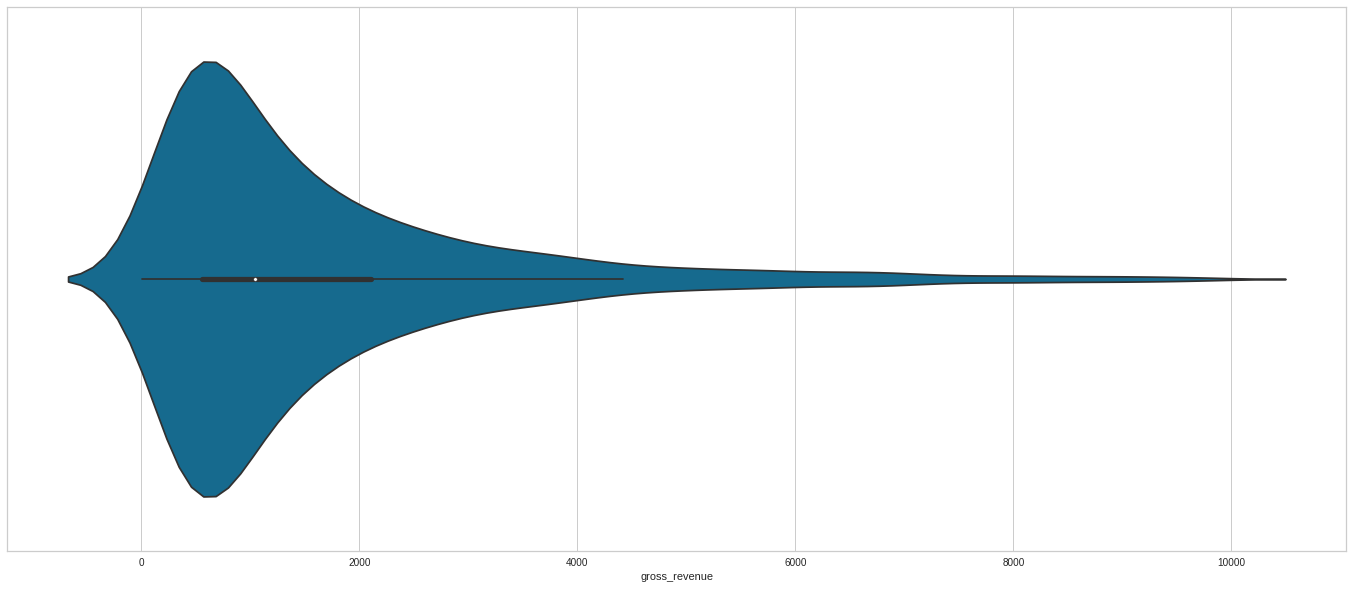

In [82]:
plt.figure(figsize=(24,10))
sns.violinplot(x=df10.loc[df10['gross_revenue']<10000,'gross_revenue']);


#### H6: Bad users tem 80% do faturamento retornado em devolução

**Falso** 3% do faturmaneto é retornado em devolução

In [83]:
df_merge = pd.merge(df2, df10[['cluster','customer_id']], on='customer_id', how='left')
df_merge = df_merge.dropna()

In [84]:
df_merge['gross_revenue'] = df_merge['unit_price']*df_merge['quantity']

returned = df_merge.loc[(df_merge['cluster']==4)&(df_merge['quantity']<0), 'gross_revenue'].sum()

purchase = df_merge.loc[(df_merge['cluster']==4)&(df_merge['quantity']>=0), 'gross_revenue'].sum()


print('Faturamento retornado em devolução: {:.1f}%'.format(abs(100*returned/(purchase-returned))))

Faturamento retornado em devolução: 3.8%


## 10.5. Quadro de Respostas

#### 1. Quem são as pessoas elegíveis para fazer parte do grupo de Insiders?

In [86]:
# df10[df10['cluster']==6].to_csv('../data/insiders.csv')

#### 2. Quantos clientes farão parte do grupo?

In [88]:
n_insiders = len(df10[df10['cluster']==6])
print('Serão {} insiders'.format(n_insiders))

Serão 255 insiders


#### 3.  Quais as principais características desses clientes?

In [89]:
df_cluster[df_cluster['cluster']==6]

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qt_products,frequency,qt_returns
6,6,255,8.591644,7760.927451,22.698039,336.72549,0.077465,81.882353


#### 4.  Qual a porcentagem de contribuição do faturamento vindo dos Insiders?

In [96]:
gmv_total = df10['gross_revenue'].sum()
gmv_insiders = df10.loc[df10['cluster']==6,'gross_revenue'].sum()

gmv_perc = (gmv_total-gmv_insiders)*100/gmv_total
print('A porcentagem de contribuição para o faturamento vindo dos insiders é de {:.2f}%'.format(gmv_perc))

A porcentagem de contribuição para o faturamento vindo dos insiders é de 75.24%


#### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

#### 6. Quais as condições para uma pessoa ser elegível ao Insiders?

#### 7.  Quais as condições para uma pessoa ser removida do Insiders?

####  8. Qual a garantia que o programa Insiders é melhor que o restante da base?

#### 9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

# 11.0. Deploy to Production